<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    FIT-HCMUS, VNU-HCM 
    <br>
    Lập trình cho khoa học dữ liệu 
    <br>
    Đồ án cuối kỳ 📌
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Đặt những câu hỏi có ý nghĩa 📌
</div>

# Thêm các thư viện cần thiết

In [36]:
import pandas as pd
import geopandas
import seaborn as sns
import numpy as np  
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Câu hỏi 1:

- Câu hỏi: Tình hình hiện tại về sự phân bố các Airbnb trên thành phố New York là như thế nào ? 
- Trả lời được câu hỏi này sẽ giúp ta thấy được sự tình hình phân bố và giá cả nhà ở theo từng khu vực ở thành phố New York. Từ đó, có thể thấy được đâu là trung tâm dựa vào đó chúng ta có thể lựa chọn Airbnb tùy theo ngân sách để có thể chi khi đi du lịch hoặc ở ngắn hạn hay là nơi đáng để đầu tư 

## Tiền xử lý 

In [37]:
raw_df = pd.read_csv('./Data/processed_data/processed_data.csv')

## Phân tích để trả lời câu hỏi 

Gom nhóm các Airbnb theo từng khu vực và tính trung bình giá cả , số lượng các Airbnb theo từng khu vực

In [38]:
aggregation_functions = {
    'price': 'mean',
    'id':'count'
}

result = raw_df.groupby(['neighbourhood_group']).agg(aggregation_functions).reset_index()
result.rename(columns={'id':'total_number_of_host'},inplace=True)
result

,neighbourhood_group,price,total_number_of_host
0,Bronx,87.496792,1091
1,Brooklyn,124.396507,20098
2,Manhattan,196.881372,21656
3,Queens,99.493997,5664
4,Staten Island,114.812332,373


Xem xét giá tiền của 2 khu vực có giá tiền cao nhất : Manhattan , Brooklyn

In [39]:
manhattan_df = raw_df[raw_df['neighbourhood_group'] == 'Manhattan']
brooklyn_df = raw_df[raw_df['neighbourhood_group'] == 'Brooklyn']

In [40]:
min_price = [min(manhattan_df['price']),min(brooklyn_df['price'])]
mean_price = [np.mean(manhattan_df['price']),np.mean(brooklyn_df['price'])]
median_price = [np.median(manhattan_df['price']),np.median(brooklyn_df['price'])]
max_price = [max(manhattan_df['price']),max(brooklyn_df['price'])]

In [41]:
price_df = pd.DataFrame({
    'Min' : min_price,
    'Mean' : mean_price,
    'Median' : median_price,
    'Max' : max_price
},index=['Manhattan','Brooklyn'])

In [42]:
price_df

,Min,Mean,Median,Max
Manhattan,0,196.881372,150.0,10000
Brooklyn,0,124.396507,90.0,10000


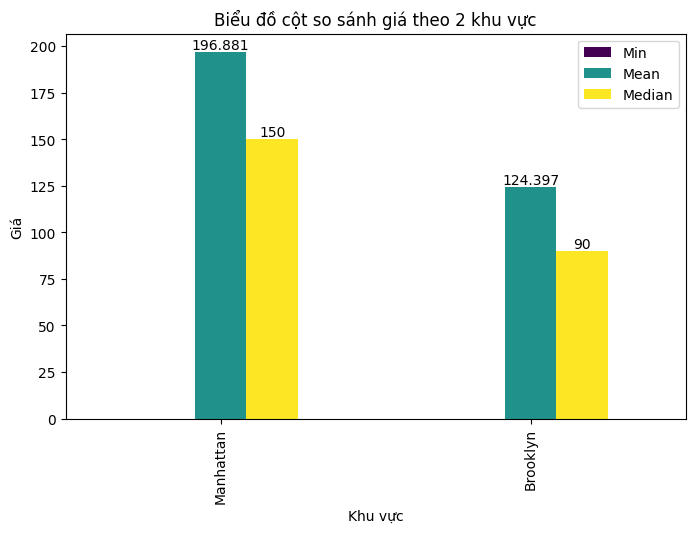

In [43]:
ax = price_df[['Min', 'Mean', 'Median']].plot(kind='bar', figsize=(8, 5), colormap='viridis')

ax.set_ylabel('Giá')
ax.set_xlabel('Khu vực')
ax.set_title('Biểu đồ cột so sánh giá theo 2 khu vực')
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.show()

- Giá tiền thấp nhất của 2 khu vực đều bằng 0 
- Giá tiền trung bình và Giá tiền trung vị của khu vực Manhattan đều lớn hơn Brooklyn ( 58%-65 %) cho thấy mức độ hot của khu vực Manhattan là lớn như thế nào so với Brooklyn dù cả 2 cùng là khu vực có nhiều căn Airbnb nhất 

Đọc file từ thư viện `geopandas` để phục vụ cho việc vẽ bản đồ , sau đó kết hợp 2 bảng 

In [44]:
city_df = geopandas.read_file(geopandas.datasets.get_path('nybb'))

result.rename(columns={'neighbourhood_group':'BoroName'}, inplace=True)
city_df = city_df.merge(right=result,how='inner',on='BoroName')
city_df

C:\Users\pc\AppData\Local\Temp\ipykernel_7036\1661923646.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  city_df = geopandas.read_file(geopandas.datasets.get_path('nybb'))


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,price,total_number_of_host
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227....",114.812332,373
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957...",99.493997,5664
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100...",124.396507,20098
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940....",196.881372,21656
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",87.496792,1091


Hình vẽ thể hiện sự phân bố của các Airbnb trên từng khu vực trong bản đồ thành phố New York 

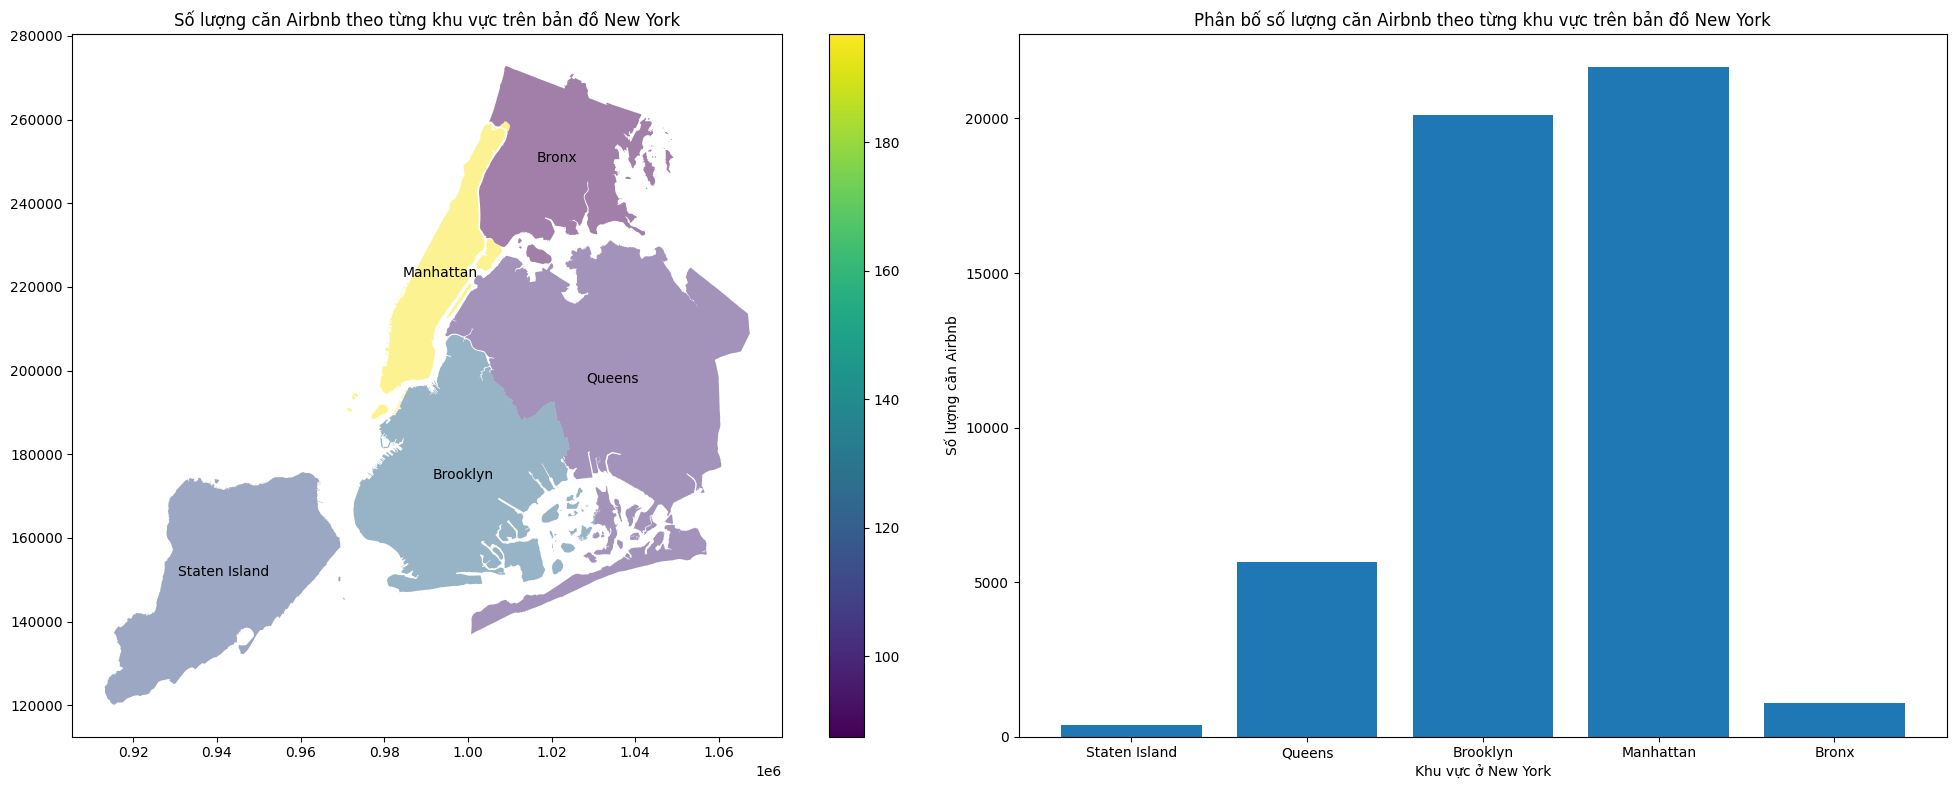

In [45]:
fig,ax = plt.subplots(1,2, figsize=(20,8))
city_df.plot(column='price' ,alpha=.5, ax=ax[0], legend=True)
city_df.apply(lambda x: ax[0].annotate(text=x.BoroName, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
ax[0].set_title("Số lượng căn Airbnb theo từng khu vực trên bản đồ New York")



ax[1].bar(city_df['BoroName'],city_df['total_number_of_host'])
ax[1].set_xlabel('Khu vực ở New York')
ax[1].set_ylabel('Số lượng căn Airbnb')
ax[1].set_title('Phân bố số lượng căn Airbnb theo từng khu vực trên bản đồ New York')
plt.tight_layout()
plt.show()

- Số lượng AirBnB tại khu vực Brooklyn và Manhattan chiếm tỷ lệ lớn trong tổng số AirBnB tại Thành phố New York. Lý do cho việc này là vì vị trí đẹp của hai khu vực này (trung tâm thành phố New York) và các địa điểm du lịch nổi tiếng của 2 khu vực này 
- Số lượng AirBnB tại khu vực State Island và Bronx chỉ chiếm một phần nhỏ trong tổng số AirBnB tại Thành phố New York. Nguyên nhân là do vị trí quá xa trung tâm và khó khăn trong việc di chuyển vào trung tâm khi State Island nằm trên một hòn đảo tách biệt với các khu vực còn lại. Mặc dù Bronx nằm cạnh Manhattan (khu vực có nhiều AirBnB nhất), nằm ở ngoại ô thành phố cũng có 1 phần nguyên do dẫn đến việc Bronx có ít AirBnB hơn.

Hình vẽ thể hiện giá của các Airbnb theo từng khu vực trong bản đồ thành phố New York 

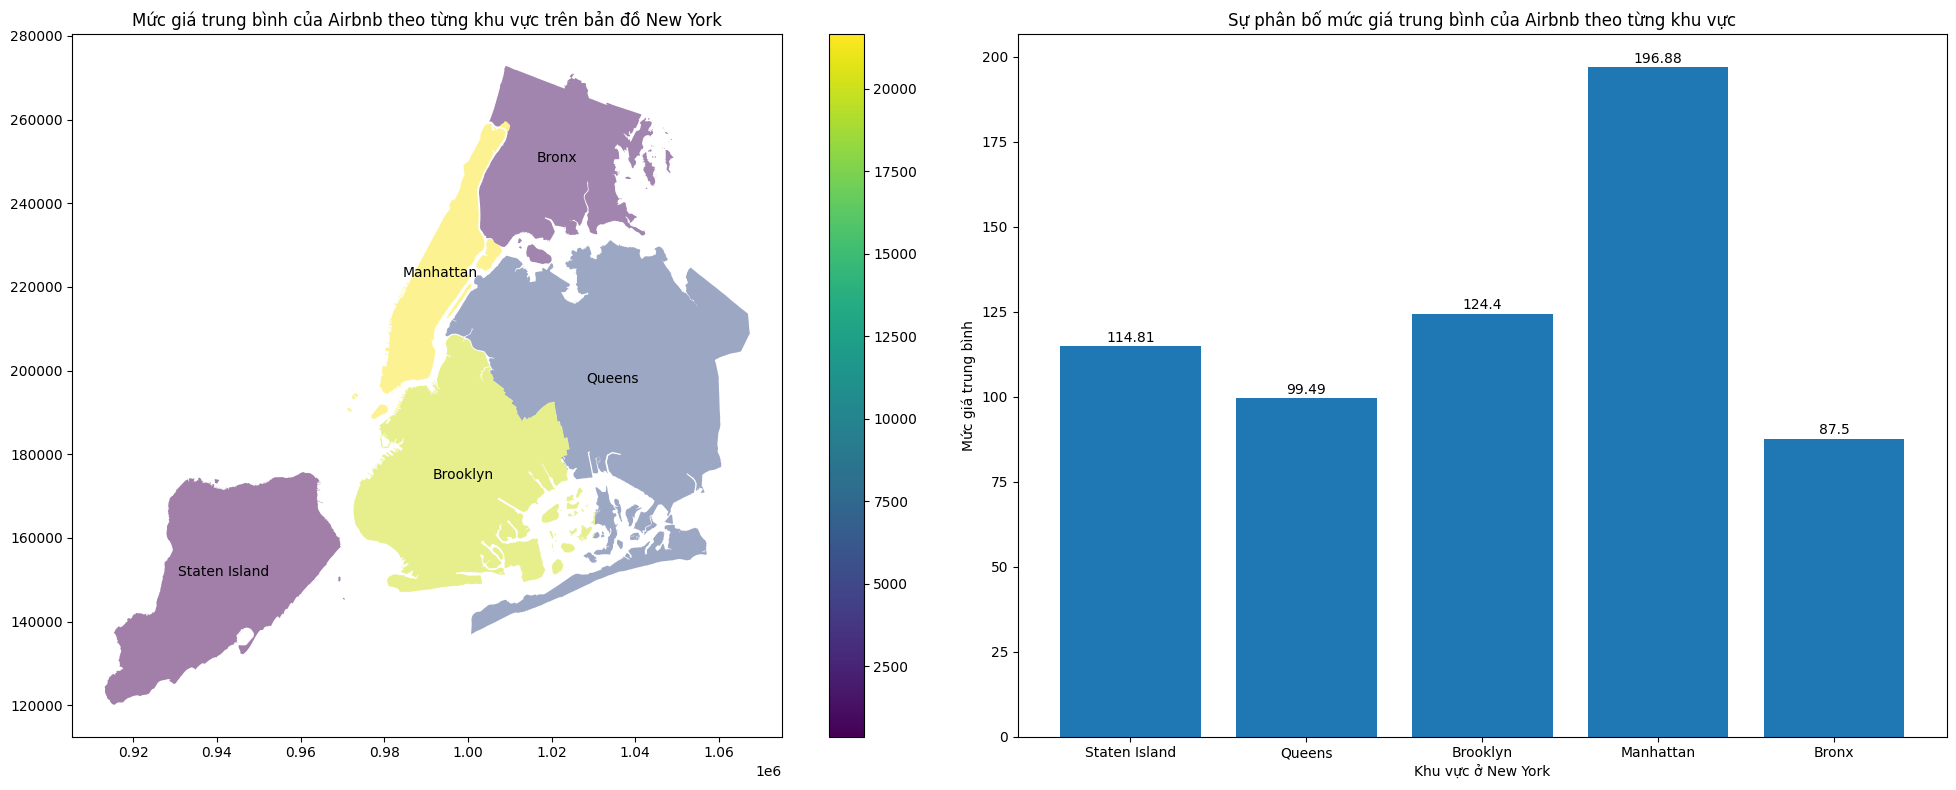

In [46]:
fig,ax = plt.subplots(1,2, figsize=(20,8))
city_df.plot(column='total_number_of_host' ,alpha=.5, ax=ax[0], legend=True)
city_df.apply(lambda x: ax[0].annotate(text=x.BoroName, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
ax[0].set_title("Mức giá trung bình của Airbnb theo từng khu vực trên bản đồ New York")

ax[1].bar(city_df['BoroName'],city_df['price'])
ax[1].set_xlabel('Khu vực ở New York')
ax[1].set_ylabel('Mức giá trung bình')
ax[1].set_title('Sự phân bố mức giá trung bình của Airbnb theo từng khu vực')
for index, value in enumerate(city_df['price']):
    ax[1].text(index, value + 0.5, str(round(value,2)), ha='center', va='bottom')
plt.tight_layout()
plt.show()

- Giá trung bình ở Manhattan cao hơn các khu vực khác khoảng 1,5 - 2 lần. Như một số lý do trong những quan sát trước đây, có một số lý do giải thích điều này.
     - Đối tượng khách hàng mục tiêu của AirBnb là khách du lịch ngắn ngày hoặc khách du lịch muốn có trải nghiệm độc đáo mà không cần nhiều ngân sách nên những căn hộ có view đẹp nhìn ra sông (Manhattan có 2 con sông ở 2 mặt đối diện là lợi thế lớn) sẽ thu hút. nhiều khách du lịch hơn.
     - Một lý do nữa là từ Manhattan, du khách có thể di chuyển đến New Jersey và ngược lại rất dễ dàng nên có thể là địa điểm thuận lợi cho du khách khi di chuyển giữa 2 thành phố này.

Kết luận :
- Số lượng rao bán và giá trung bình tại Manhattan thuộc top đầu thành phố New York nhờ vị trí địa lý tuyệt vời. Là nơi tốt để đi du lịch nhiều thành phố khi Manhattan gần như  là trung tâm của Thành phố New York và từ Manhattan có thể di chuyển thuận tiện đến các thành phố khác cũng như là Manhattan có nhiều địa điểm hấp dẫn như Tòa nhà Empire State, Madison Square Garden,..
- Queens và Brooklyn thích hợp cho những ai thích khám phá New York vì nằm ở vị trí trung tâm và thuận tiện cho du khách di chuyển đến các khu vực khác. Tuy nhiên, có sự chênh lệch cả về giá lẫn số lượng lựa chọn giữa Queens và Brooklyn khi số lượng AirBnbs ở Brooklyn rất lớn và giá cũng cao hơn ở Queens khoảng 24%.
- Bronx và State Island đều có số lượng rao bán ít nhưng có sự chênh lệch về giá ở 2 khu vực này khi giá của Airbnb ở State Island cao hơn Bronx khoảng 30$

# Câu hỏi 2:

- Câu hỏi: Tình hình thị trường các căn hộ có giá trên 1000$ 1 đêm với số đêm tối thiểu ít hơn 2 ngày diễn ra như thế nào?
- Trả lời câu hỏi này sẽ giúp khách hàng so sánh mức giá, số lượng đánh giá, cũng như giúp đưa ra quyết định thuê một khu vực nào đó. Hơn nữa, có thể giúp nhà đầu tư nhìn được tổng quan thị trường các căn hộ (có giá trên 1000$ 1 đêm và thời hạn thuê tối thiểu ít hơn 2 ngày).

## Tiền xử lí

In [47]:
df = pd.read_csv('./Data/processed_data/processed_data.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Để trả lời câu hỏi trên, ta cần các cột sau:
- `id`: Để phân biệt các căn hộ với nhau.	
- `neighbourhood_group`: Để xác định khu vực của các các hộ.
- `room_type`: Xác định loại phòng của các căn hộ.
- `price`: Xác định mức giá của các căn hộ.	
- `minimum_nights`: Xác định số đêm tối thiểu đặt phòng.
- `number_of_reviews`: Xác định mức độ phổ biến, viral của căn hộ để đề xuất cho nhóm khách hàng.

In [48]:
column_list = ['id',
              'neighbourhood_group', 
              'room_type', 
              'price', 
              'minimum_nights', 
              'number_of_reviews']
new_df = df[column_list]
new_df.head()

,id,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews
0,2539,Brooklyn,Private room,149,1,9
1,2595,Manhattan,Entire home/apt,225,1,45
2,3647,Manhattan,Private room,150,3,0
3,3831,Brooklyn,Entire home/apt,89,1,270
4,5022,Manhattan,Entire home/apt,80,10,9


Lấy ra các căn hộ ở các khu vực mà có giá hơn 1000 USD một đêm và có thời gian lưu trú tối thiểu một hoặc hai đêm.

In [49]:
df_satisfied =  new_df[(new_df['price'] >= 1000) & (new_df['minimum_nights'] <= 2)]
df_satisfied.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1105 to 48522
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   160 non-null    int64 
 1   neighbourhood_group  160 non-null    object
 2   room_type            160 non-null    object
 3   price                160 non-null    int64 
 4   minimum_nights       160 non-null    int64 
 5   number_of_reviews    160 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 8.8+ KB


## Phân tích để trả lời câu hỏi

In [50]:
group_counts  = df_satisfied.groupby('neighbourhood_group').count()['id']
group_counts

neighbourhood_group
Bronx              2
Brooklyn          41
Manhattan        110
Queens             5
Staten Island      2
Name: id, dtype: int64

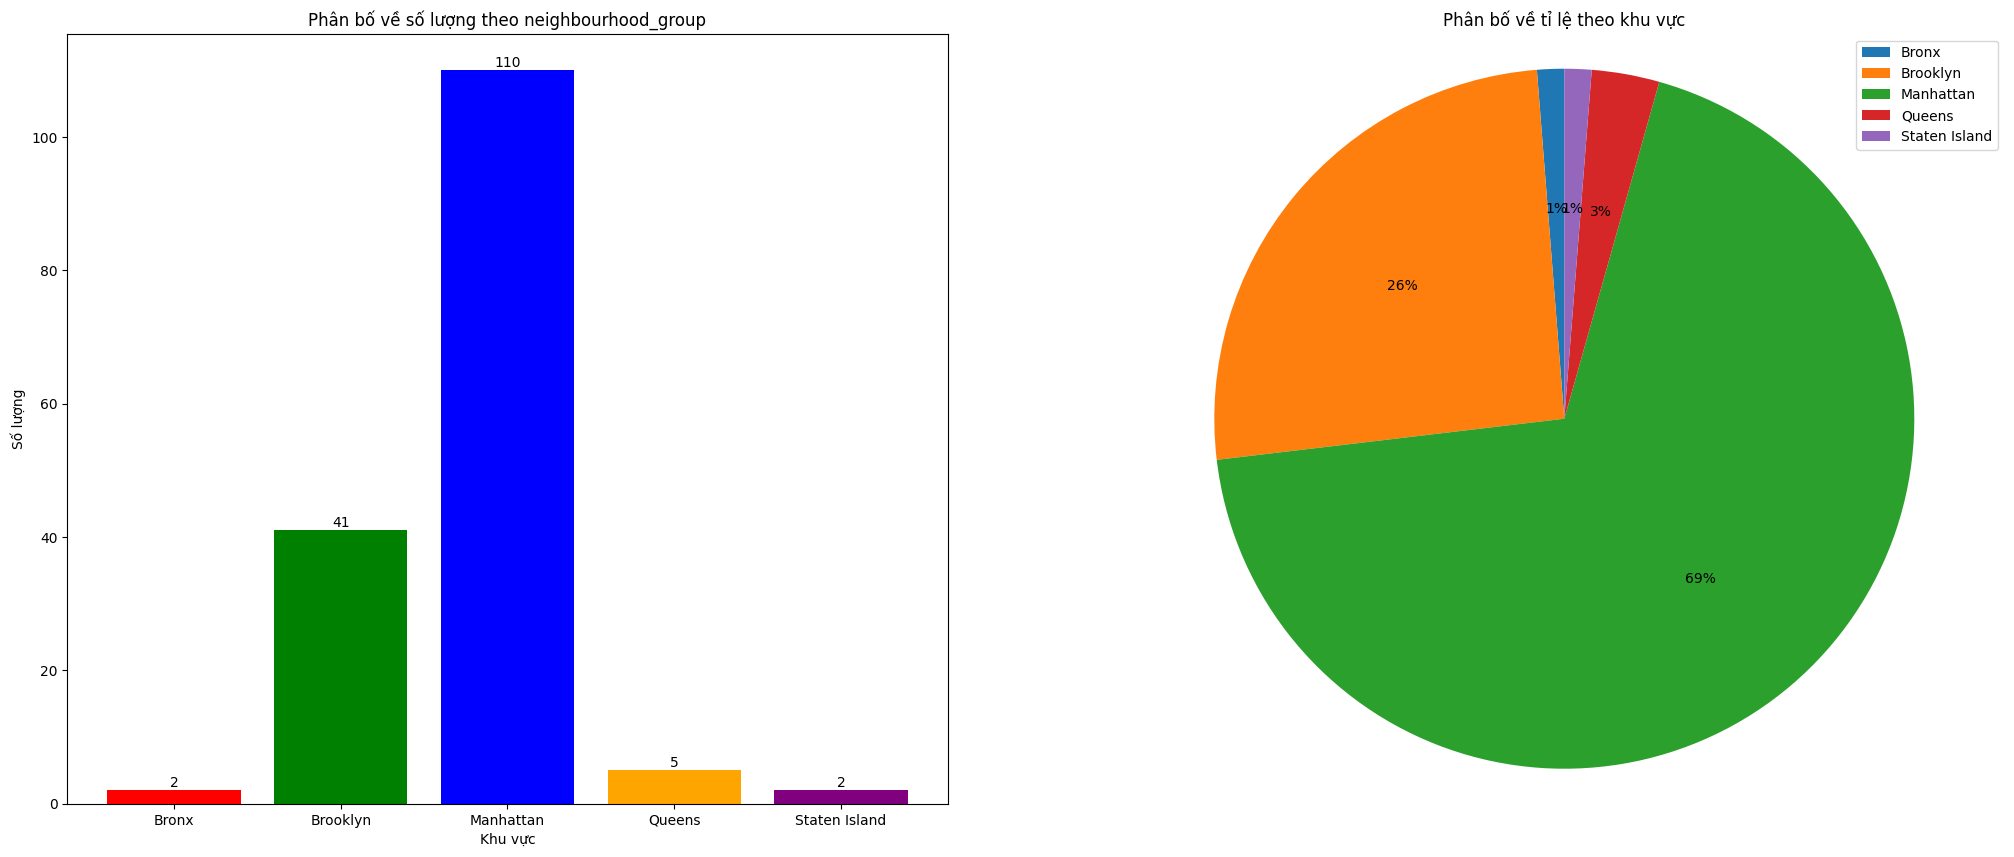

In [51]:
fig, axes = plt.subplots(1,2,figsize=(25,10))

axes[0].bar(group_counts.index, group_counts.values, color=['red', 'green', 'blue', 'orange', 'purple'])
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('Phân bố về số lượng theo neighbourhood_group')
axes[0].set_xlabel('Khu vực')
axes[0].set_ylabel('Số lượng')

axes[1].pie(group_counts.values, labels=None, autopct='%1.f%%', startangle=90)
axes[1].legend(labels=group_counts.index, loc='upper right')
axes[1].set_title('Phân bố về tỉ lệ theo khu vực')
axes[1].axis('equal') 

plt.show()

> Có thể thấy, có tất cả 160 căn hộ có giá trên 1000$ và số đêm ở tối thiểu <= 2. Brooklyn có 41 (chiếm 69%), Manhattan có 110 (chiếm 26%), Queens có 5 (chiếm 3%), Bronx và Staten Island có 2 phòng hạng sang có giá hơn 1000$ (chiếm 1%).

> Có thể thấy, trong 5 khu vực (Bronx, Brooklyn, Manhattan, Queens và Staten Island) thì chủ yếu có 2 khu vực đáp ứng được nhu cầu của nhóm khách hàng chúng ta đang hướng đến đó là Brooklyn và Manhattan. Ba khu vực còn lại là Bronx, Queens và Staten Island có số lượng căn hộ phù hợp với yêu cầu là khá ít.

Tiếp theo, ta xem xét số lượng các loại phòng phù hợp với yêu cầu đưa ra

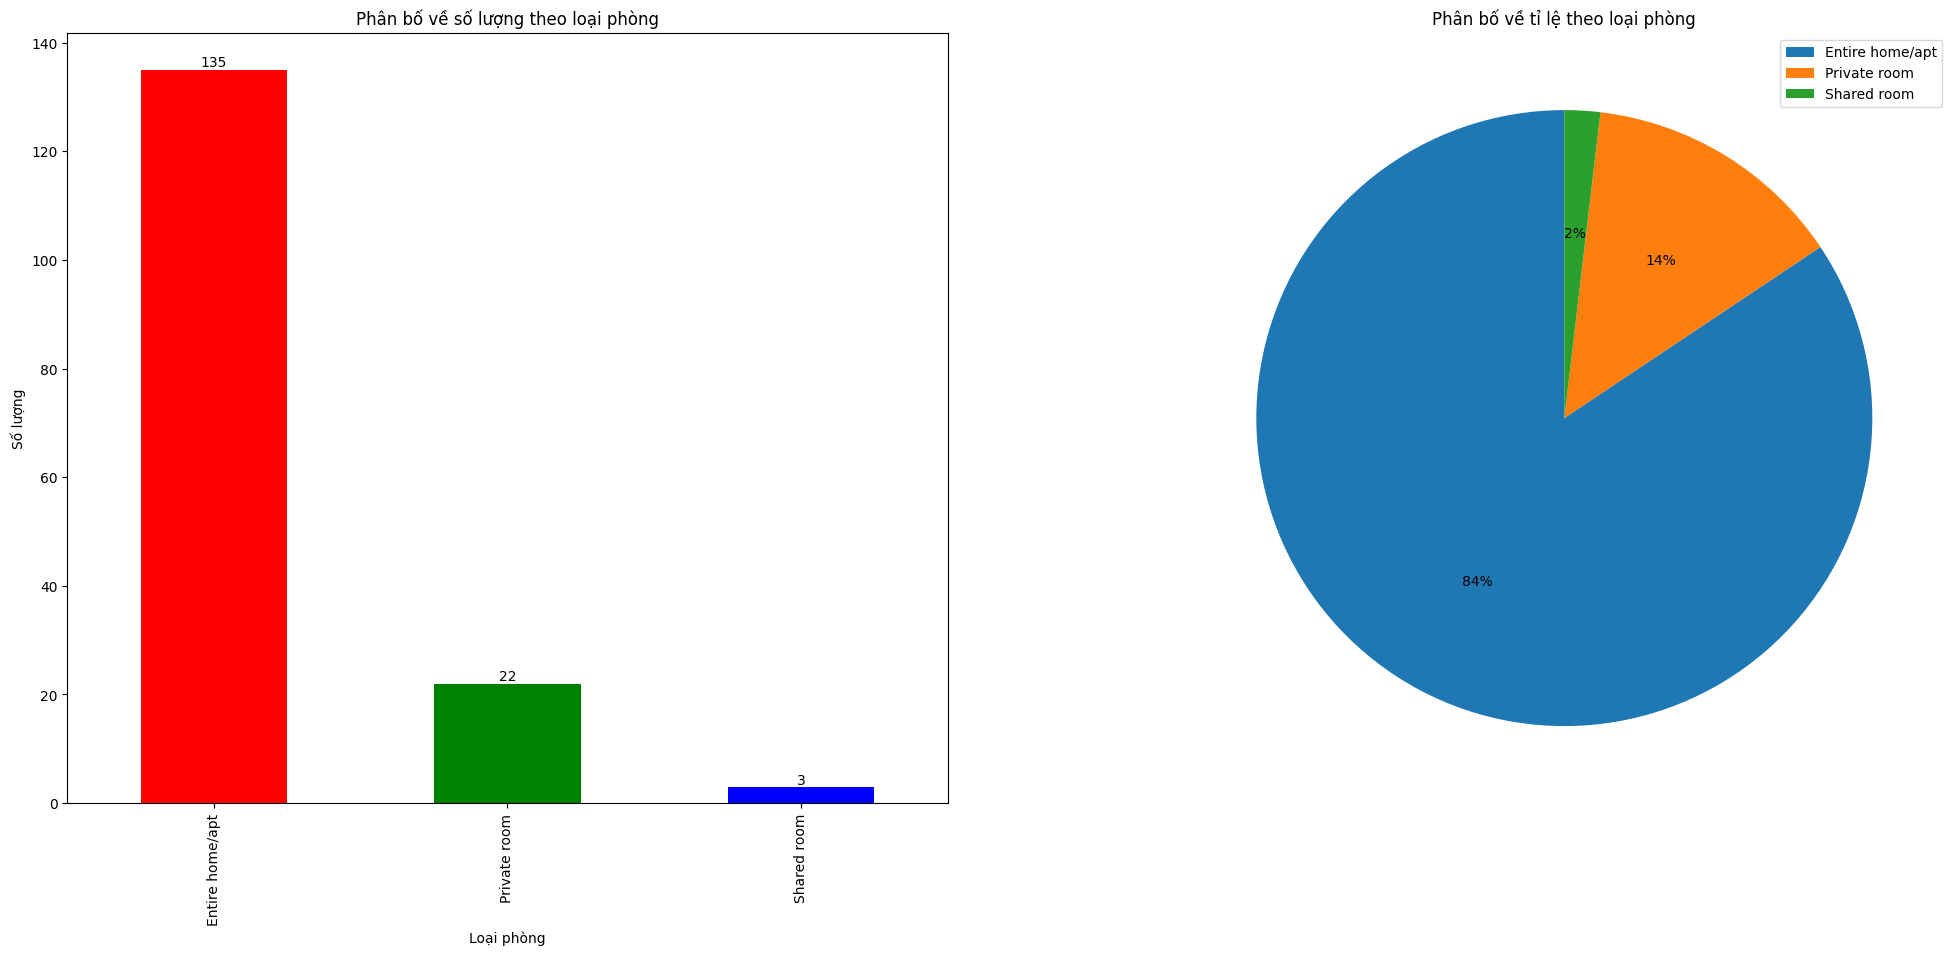

In [52]:
fig, axes = plt.subplots(1,2,figsize=(25,10))

df_satisfied['room_type'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green', 'blue'])
axes[0].bar_label(axes[0].containers[0])
axes[0].set_ylabel('Count')
axes[0].set_title('Phân bố về số lượng theo loại phòng')
axes[0].set_xlabel('Loại phòng')
axes[0].set_ylabel('Số lượng')

df_satisfied['room_type'].value_counts().plot(kind='pie', ax=axes[1], legend=True, labels=None, autopct='%1.f%%', startangle=90)
axes[1].set_ylabel(None)
axes[1].set_title('Phân bố về tỉ lệ theo loại phòng')
plt.show()

> Có thể thấy, loại phòng chiếm tỉ lệ nhiều nhất chính là `Entire home/apt` (84%), tiếp theo là `Private room` (14%) và `Shared room` (2%)

Tiếp theo, ta xem xét mức giá trung bình của các căn hộ theo loại phòng và số đêm ở tối thiểu

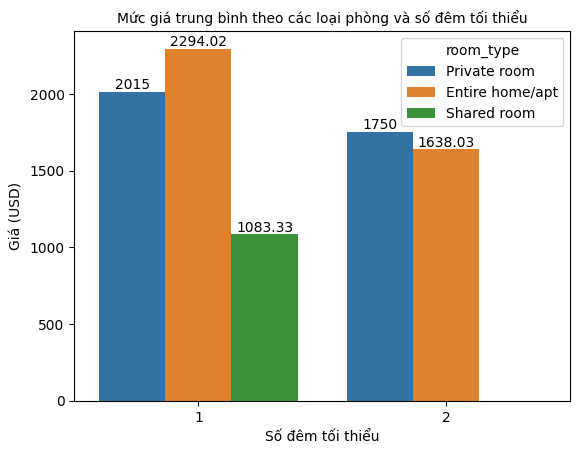

In [53]:
ax = sns.barplot(data=df_satisfied, x = 'minimum_nights', y = 'price', hue='room_type', errorbar=None)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.set_title('Mức giá trung bình theo các loại phòng và số đêm tối thiểu', fontsize=10)
ax.set_xlabel('Số đêm tối thiểu')
ax.set_ylabel('Giá (USD)')
plt.show()

> Có thể thấy, với số đêm ở tối thiểu là 2, thì ta chỉ có 2 loại phòng (Private room và Entire home/apt); với số đêm ở tối thiểu là 1, thì ta có cả 3 loại phòng (Private room, Entire home/apt và Shared room)

> Giá trung bình của các căn hộ là khác nhau với các loại phòng khác nhau. Với các căn hộ có thời gian thuê tối thiểu là 2 đêm, giá giữa các loại phòng chênh lệch nhau không nhiều (khoảng 100$). Mặt khác, với các căn hộ có thời gian thuê tối thiểu là 1 đêm, giá của các căn hộ ấy chênh lệch khá nhiều (từ 300$ đến 1000$)  

Ta xem xét mức giá trung bình của các căn hộ theo loại phòng và khu vực

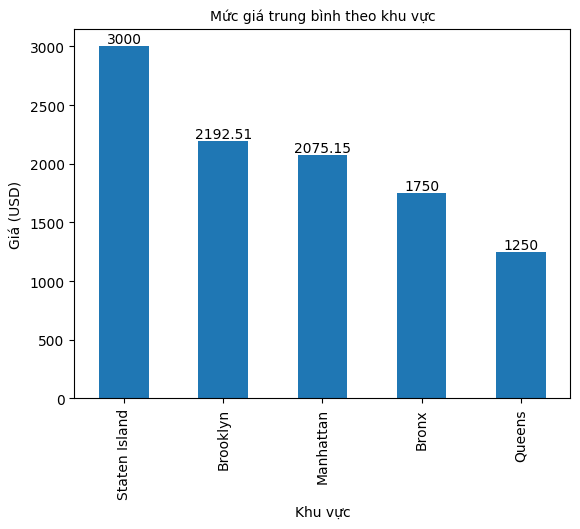

In [54]:
ax = df_satisfied[['neighbourhood_group', 'price']].groupby('neighbourhood_group').mean().sort_values(by='price', ascending=False).plot(kind='bar', legend=None)
ax.bar_label(ax.containers[0])
ax.set_title('Mức giá trung bình theo khu vực', fontsize=10)
ax.set_xlabel('Khu vực')
ax.set_ylabel('Giá (USD)')
plt.show()

> Có thể thấy, State Island có giá trung bình là cao nhất (3000$), tiếp theo là đến Manhattan, Brooklyn, Bronx và Queens.

Ta xem xét mức giá cao nhất của các căn hộ theo loại phòng và khu vực

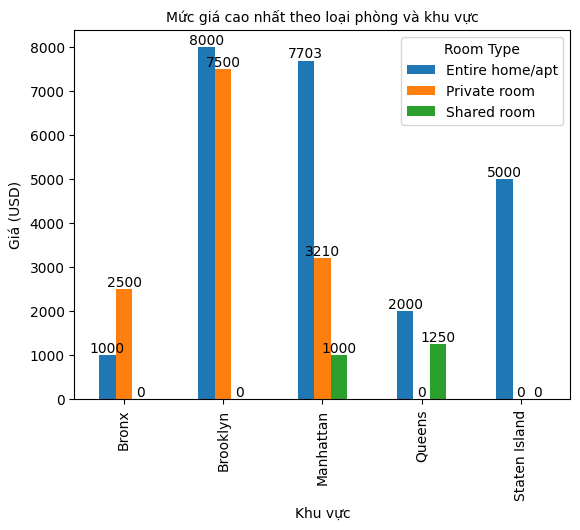

In [55]:
ax = df_satisfied[['neighbourhood_group', 'room_type', 'price']].groupby(['neighbourhood_group', 'room_type']).max().unstack(1).plot(kind='bar', legend=None)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.legend(title='Room Type', labels=['Entire home/apt', 'Private room', 'Shared room'], loc='upper right')
ax.set_title('Mức giá cao nhất theo loại phòng và khu vực', fontsize=10)
ax.set_xlabel('Khu vực')
ax.set_ylabel('Giá (USD)')
plt.show()

> Ở hầu hết các khu vực, loại phòng Entire home/apt có mức giá cao nhất (trừ Bronx)

> Khu vực Brooklyn có mức giá cao nhất với 8000$ 1 đêm ở loại phòng Entire home/apt

> Khu vực Queens có mức giá thấp nhất với 2000$

Ta xem xét số lượng review tại mỗi khu vực

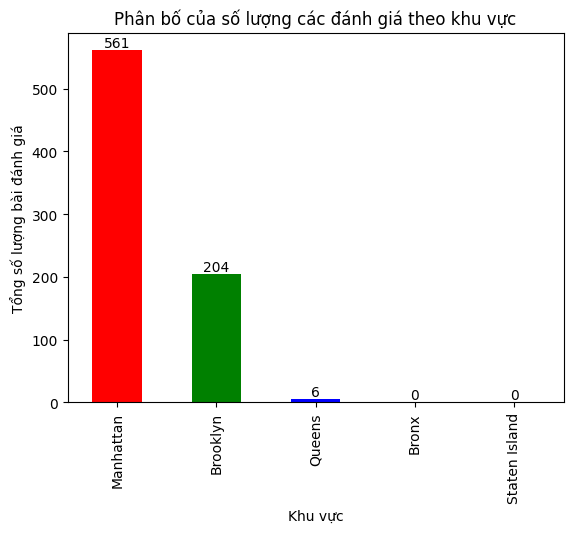

In [56]:
ax = df_satisfied.groupby('neighbourhood_group').sum()['number_of_reviews'].sort_values(ascending=False).plot(kind='bar', color=['red', 'green', 'blue', 'orange', 'purple'])
ax.bar_label(ax.containers[0])

plt.xlabel('Khu vực')
plt.ylabel('Tổng số lượng bài đánh giá')
plt.title('Phân bố của số lượng các đánh giá theo khu vực')

plt.show()

> Có thể thấy Mahattan, Brooklyn có số lượng review cao nhất, cho thấy các căn hộ 2 khu vực này được nhiều người quan tâm đến. 

## Kết luận

- Từ phân tích và trực quan hóa trên, có thể kết luận rằng Airbnb có các phòng đắt đỏ hầu hết nằm ở khu vực Brooklyn và Manhattan; đa phần là entire home/apt và private room. Mặc dù Manhattan có số lượng thông tin đăng cao nhất về các phòng sang trọng. Tuy nhiên, phòng đắt đỏ nhất lại nằm ở Brooklyn, đó là căn airbnb loại entire home/apt và có giá là 8000 đô la mỗi đêm.
- Qua các phân tích trên, ta thấy được tổng quan thị trường Airbnb đắt đỏ ở New York qua từng đặc điểm như số lượng căn hộ, loại căn hộ, mức giá,...
- Người dùng và nhà đầu tư dùng các phân tích trên để từ đó có thể đưa ra các quyết định của mình. (Ví dụ đối với các nhà đầu tư, có thể xem xét đầu tư xây dựng thêm nhiều căn hộ ở các vùng như Queens, Bronx, Staten Island vì các khu vực này số lượng phòng đạt yêu cầu còn khá ít)

# Câu hỏi 3:

- Câu hỏi: Làm sao có thể dự đoán được giá của một căn airbnb (giả sử đang hướng đến thị trường có mức giá dưới 1000$ một đêm)?
- Trả lời được câu hỏi này sẽ giúp người đặt phòng dự đoán được giá của căn hộ mình cần thuê, cũng như giúp chủ các căn hộ đưa ra mức giá phù hợp cho căn hộ của mình.

## Tiền xử lí

In [57]:
df = pd.read_csv('./Data/processed_data/processed_data.csv')

Đầu tiên, ta sẽ lấy ra các phòng thỏa mãn yêu cầu mà chúng ta đa hướng tới, đó là bài đăng của các căn airbnb có giá dưới 1000$

In [58]:
df_satisfied = df[df['price'] < 1000]
df_satisfied.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Tiếp theo, ta sẽ xem xét sự phân bố của 'price' đối với cắc căn airbnb có giá dưới 1000$

In [59]:
df_satisfied['price'].describe()

count    48584.000000
mean       140.240326
std        112.911413
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        999.000000
Name: price, dtype: float64

Ta sẽ không chọn những căn airbnb có giá bằng 0$ một đêm vì những mẫu này không có giá trị trong bài toán mà ta đang xem xét

In [60]:
df_satisfied = df_satisfied.drop(index=df_satisfied[df_satisfied['price'] == 0].index)

In [61]:
df_satisfied['price'].describe()

count    48573.000000
mean       140.272085
std        112.904471
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        999.000000
Name: price, dtype: float64

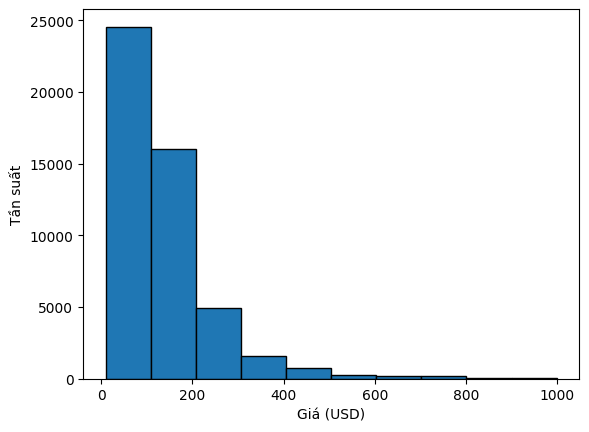

In [62]:
ax = df_satisfied['price'].plot(kind='hist', edgecolor='black')
ax.set_ylabel('Tần suất')
ax.set_xlabel('Giá (USD)')
ax.set_label('Biểu đồ thể hiện sự phân bố của các mức giá')
plt.show()

> Có thể thấy, có tổng cộng 48645 căn airbnb có mức giá dưới 1000$ một đêm. Mức giá của các căn dao động từ 10$ đến 1000$ một đêm. Trong đó, đa số giá của các căn tập trung ở khu vực từ 10$ đến 175$

Tiếp theo, ta sẽ loại bỏ các cột mà không có giá trị đóng góp vào bài toán mà ta đang xem xét

In [63]:
df_satisfied = df_satisfied.drop(columns=['host_id', 'name','id','host_name', 'neighbourhood'])
df_satisfied

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...
48877,Brooklyn,40.67853,-73.94995,Private room,70,2,0,0.00,2,9
48878,Brooklyn,40.70184,-73.93317,Private room,40,4,0,0.00,2,36
48879,Manhattan,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,27
48880,Manhattan,40.75751,-73.99112,Shared room,55,1,0,0.00,6,2


Tiếp theo, ta sẽ lấy các cột có giá trị là categorical. Ta sẽ xử lý các cột này bằng cách sử dụng one-hot enconding

In [64]:
categorical_column_list = df_satisfied.select_dtypes(include='object').columns.to_list()
categorical_column_list

['neighbourhood_group', 'room_type']

In [65]:
df_one_hot = pd.get_dummies(df_satisfied, columns= categorical_column_list, prefix=['ng', 'rt'], drop_first=True)
df_one_hot

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ng_Brooklyn,ng_Manhattan,ng_Queens,ng_Staten Island,rt_Private room,rt_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,True,False,False,False,True,False
1,40.75362,-73.98377,225,1,45,0.38,2,355,False,True,False,False,False,False
2,40.80902,-73.94190,150,3,0,0.00,1,365,False,True,False,False,True,False
3,40.68514,-73.95976,89,1,270,4.64,1,194,True,False,False,False,False,False
4,40.79851,-73.94399,80,10,9,0.10,1,0,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48877,40.67853,-73.94995,70,2,0,0.00,2,9,True,False,False,False,True,False
48878,40.70184,-73.93317,40,4,0,0.00,2,36,True,False,False,False,True,False
48879,40.81475,-73.94867,115,10,0,0.00,1,27,False,True,False,False,False,False
48880,40.75751,-73.99112,55,1,0,0.00,6,2,False,True,False,False,False,True


## Phân tích để trả lời câu hỏi

Đầu tiên, ta sẽ chia dữ liệu thành 2 tập train và test

In [66]:
X = df_one_hot.drop(['price'], axis=1)
Y = df_one_hot['price']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Tiếp theo, ta sẽ khởi tạo các model Linear Regression, Random Forest; các hyperparameters cho từng model và các list lưu trữ kết quả của các model

In [67]:
models = [('LR', LinearRegression()),
          ('RF', RandomForestRegressor())]

param_grids = {
    'LR': {},
    'RF': {'n_estimators': [30, 50], 'max_depth': [None, 10]}
}

rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []

Thực hiện quá trình tìm ra hyperparameter tốt nhất, train và test cho từng model

In [68]:
for name, regressor in models:
    print(f"Hyperparameter Tuning for {name}:")
    start_time = time.time()


    if param_grids[name]:
        # Find best hyperparameter for model, then train the model
        grid_search = GridSearchCV(regressor, param_grid=param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_

        print(f"Best parameters: {grid_search.best_params_}")
    else:
        best_model = regressor.fit(x_train, y_train)

    # Test model
    y_pred = best_model.predict(x_test)

    # Calculate some metric to evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    execution_time = time.time() - start_time

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    execution_times.append(execution_time)

Hyperparameter Tuning for LR:
Hyperparameter Tuning for RF:


Best parameters: {'max_depth': 10, 'n_estimators': 50}


In [69]:
result = pd.DataFrame({'RMSE':rmse_scores,
                        'R2 score': r2_scores,
                        'MAE': mae_scores,
                        'MSE': mse_scores,
                        'Execution Time': execution_times}, index=['Linear Regression', 'Random Forest'])
result

,RMSE,R2 score,MAE,MSE,Execution Time
Linear Regression,92.268321,0.328219,55.329452,8513.443150,0.014168
Random Forest,83.595201,0.448576,47.581866,6988.157559,30.105846


## Kết luận

Thực hiện visualize kết quả

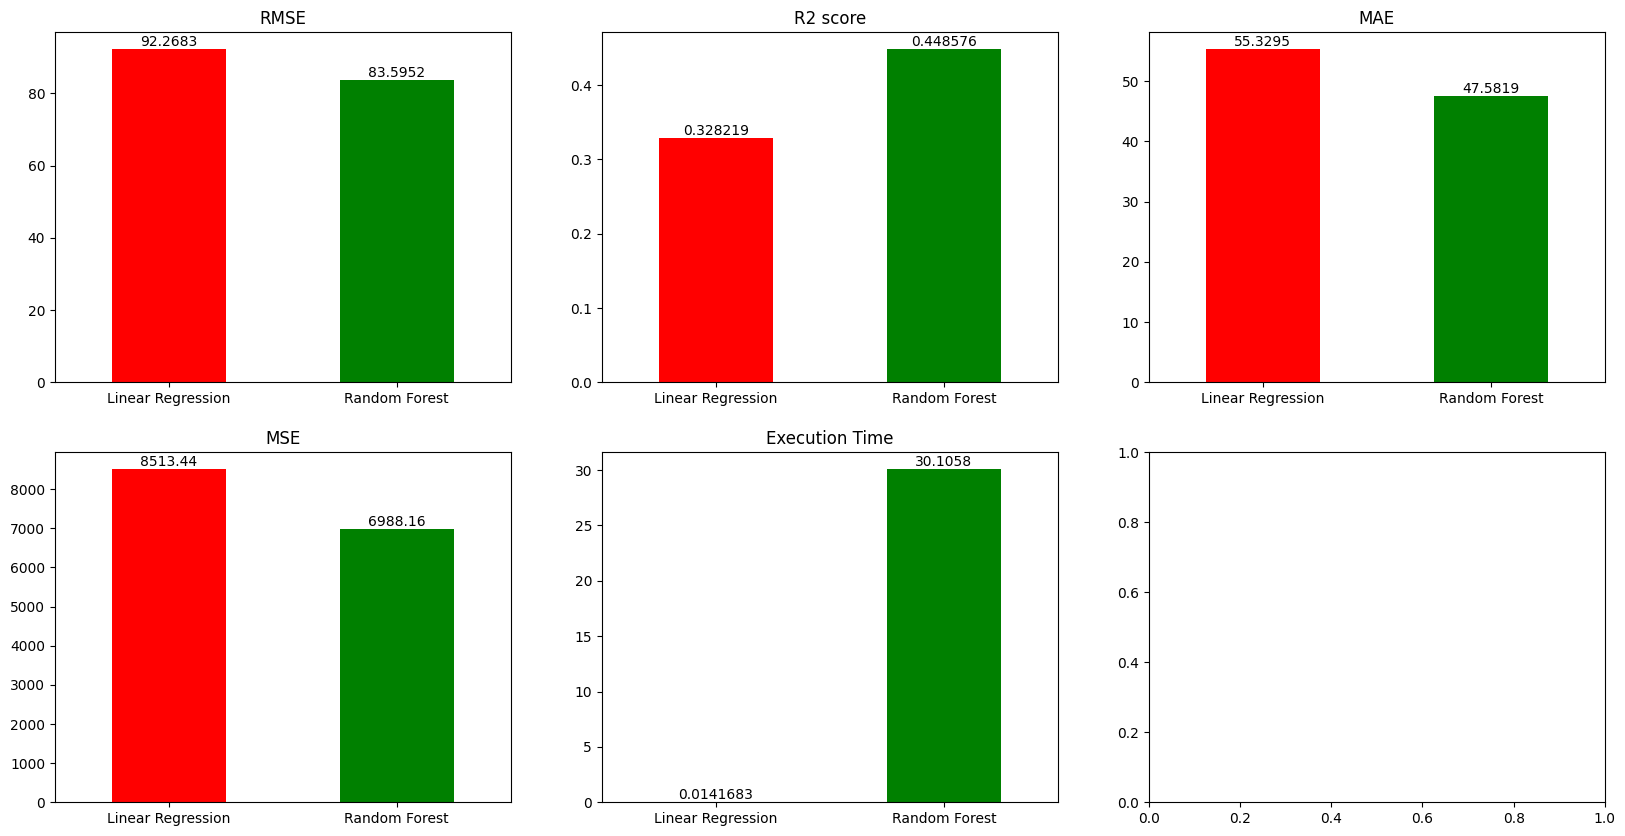

In [70]:
fig, axes = plt.subplots(2,3,figsize=(20,10))
axes = axes.flatten()
for i, col_name in enumerate(result.columns):
    result[col_name].plot(kind='bar', ax=axes[i], rot=0, color=['red', 'green'])
    axes[i].bar_label(axes[i].containers[0])
    axes[i].set_title(f'{col_name}')
plt.show()

> Có thể thấy, Random Forest cho ra hiệu suất tốt nhất trong hai mô hình, với RMSE thấp (84) và R2 Score cao (0.45). Tuy nhiên, thời gian thực hiện là khá lâu (30 giây)

> Dựa vào các phân tích ở trên, ta sẽ giúp người dùng và các nhà đầu tư dự đoán được mức giá của các căn airbnb thông qua mô hình Random Forest mà ta đã thực hiện xây dựng.